In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Load Data

In [35]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [36]:
N = list(full_signals.values())[0].shape[2]
T = list(full_signals.values())[0].shape[1]
dt = 0.01

In [37]:
noise_sd = 1e-3
normalize = True
# indices = np.random.choice(np. arange(N), size=(50,), replace=False)
indices = pd.read_pickle(os.path.join(chaotic_net_path, "indices.pkl"))
signals = {}
for key in full_signals.keys():
    signals[key] = full_signals[key][0][:, indices] 
    if normalize:
        signals[key] = (signals[key] - signals[key].mean())/signals[key].std()
    signals[key] += np.random.randn(T, len(indices))*noise_sd

# Parameter Picking

In [38]:
# parameter grid
window_vals = np.array([10000])
# window_vals = np.array([10000])
# p_vals = np.array([50, 60, 70, 80, 90, 100])
p_vals = np.array([30])
# r_thresh_vals=np.array([0.3, 0.4, 0.5])
r_thresh_vals = np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 5, 10])
lamb_vals = np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1])
# lamb_vals = np.array([0, 1e-3])
reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
parameter_grid = ParameterGrid(window_vals=window_vals, p_vals=p_vals, r_thresh_vals=r_thresh_vals, lamb_vals=lamb_vals, reseed_vals=reseed_vals)

prediction_time = 3000

In [39]:
results = {}
for key, signal in signals.items():
    print("-"*50)
    print(f"g = {key}")
    print("-"*50)
    
    window = window_vals[0]
    p = p_vals[0]
    
#     signal = (signal - signal.mean())/signal.std()
    
    train_signal = signal[:window]
    test_signal = signal[window:window + prediction_time]
    
    results[key] = parameter_search(train_signal, test_signal, parameter_grid, dt=dt, verbose=True, use_torch=True, device='cuda')

--------------------------------------------------
g = 0.8
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 0.9
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.1
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.2
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.3
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.4
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.5
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.6
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.7
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.8
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.9
--------------------------------------------------


  0%|          | 0/1904 [00:00<?, ?it/s]

In [49]:
# pd.to_pickle(results, os.path.join(chaotic_net_path, "chaotic_nets_grid_search_df_normed_noise1e-3.pkl"))
results = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_nets_grid_search_df_normed_2.pkl"))

# PLOT A CORRELATION OF TOP 0.1 and TOP10 STAB WITH ML as a FUNCTION OF R_THRESH

In [41]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
# keys = list(results.keys())
# lamb = 1e-3
lamb = 0
top_percent = 0.001

mean_over_r_thresh_vals = []
r_thresh_vals = results[keys[0]][results[keys[0]].lamb == lamb].r_thresh
for key in keys:
    mean_over_r_thresh_vals.append(results[key][results[key].lamb == lamb].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy())
mean_over_r_thresh_vals = np.array(mean_over_r_thresh_vals)

lyap_correls = [scipy.stats.pearsonr(mean_over_r_thresh_vals[:, i], [lyaps[key][:1].mean() for key in keys])[0] for i in range(mean_over_r_thresh_vals.shape[1])]
lyap_r2 = [r2_score(mean_over_r_thresh_vals[:, i], [lyaps[key][:1].mean() for key in keys]) for i in range(mean_over_r_thresh_vals.shape[1])]

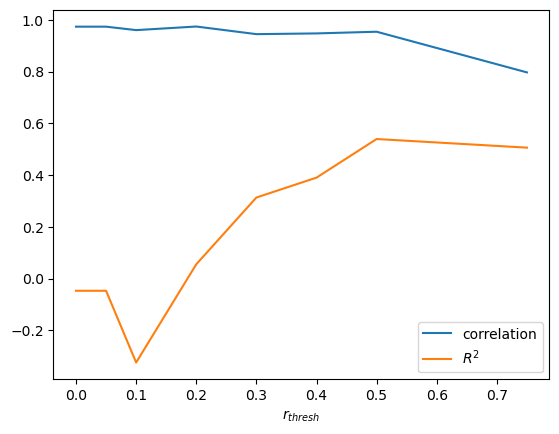

In [42]:
start = 0
end = 11
plt.plot(r_thresh_vals.iloc[start:end], lyap_correls[start:end], label='correlation')
plt.plot(r_thresh_vals.iloc[start:end], lyap_r2[start:end], label='$R^2$')
plt.legend()
plt.xlabel('$r_{thresh}$')
plt.show()

# Plot All Combos

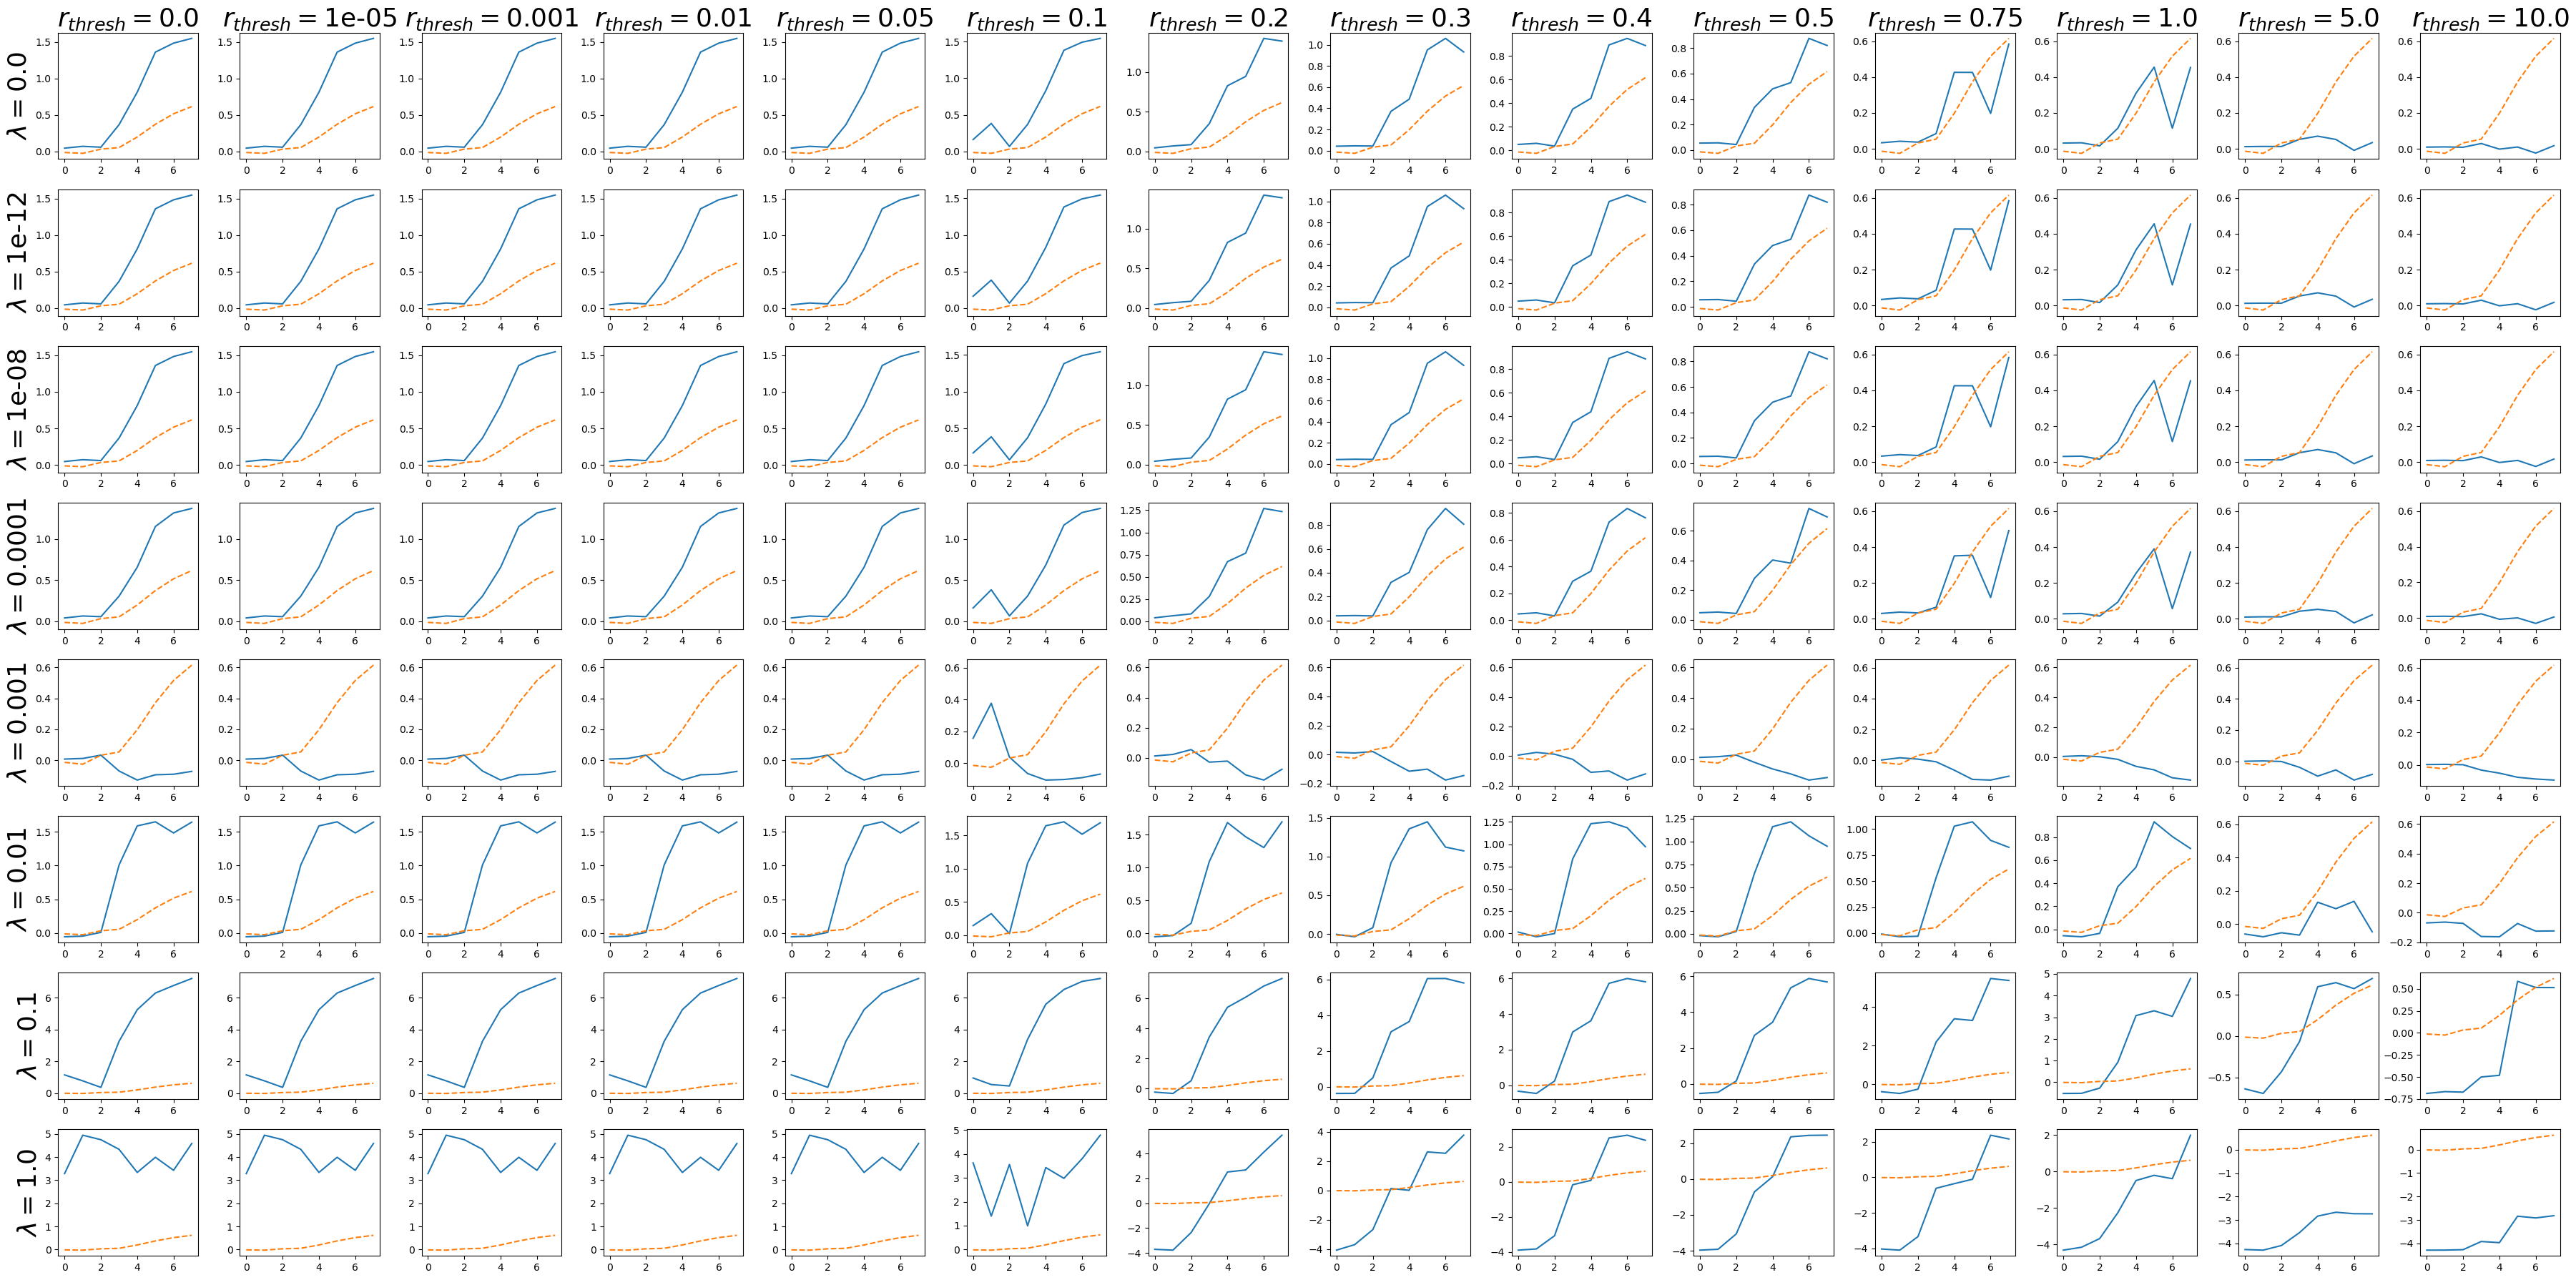

In [43]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
top_percent = 0.001
r_thresh_vals = results[keys[0]].r_thresh.unique()
lamb_vals = results[keys[0]].lamb.unique()

fig, axs = plt.subplots(len(lamb_vals), len(r_thresh_vals), figsize=(36, 18))
for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = [results[key][np.logical_and(results[key].r_thresh == r_thresh, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy()[0] for key in keys]
        ax = axs[j, i]
        ax.plot(curve)
        ax.plot([lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r_{thresh} = $" + f"{r_thresh}", fontsize=26)
plt.tight_layout()
plt.show()

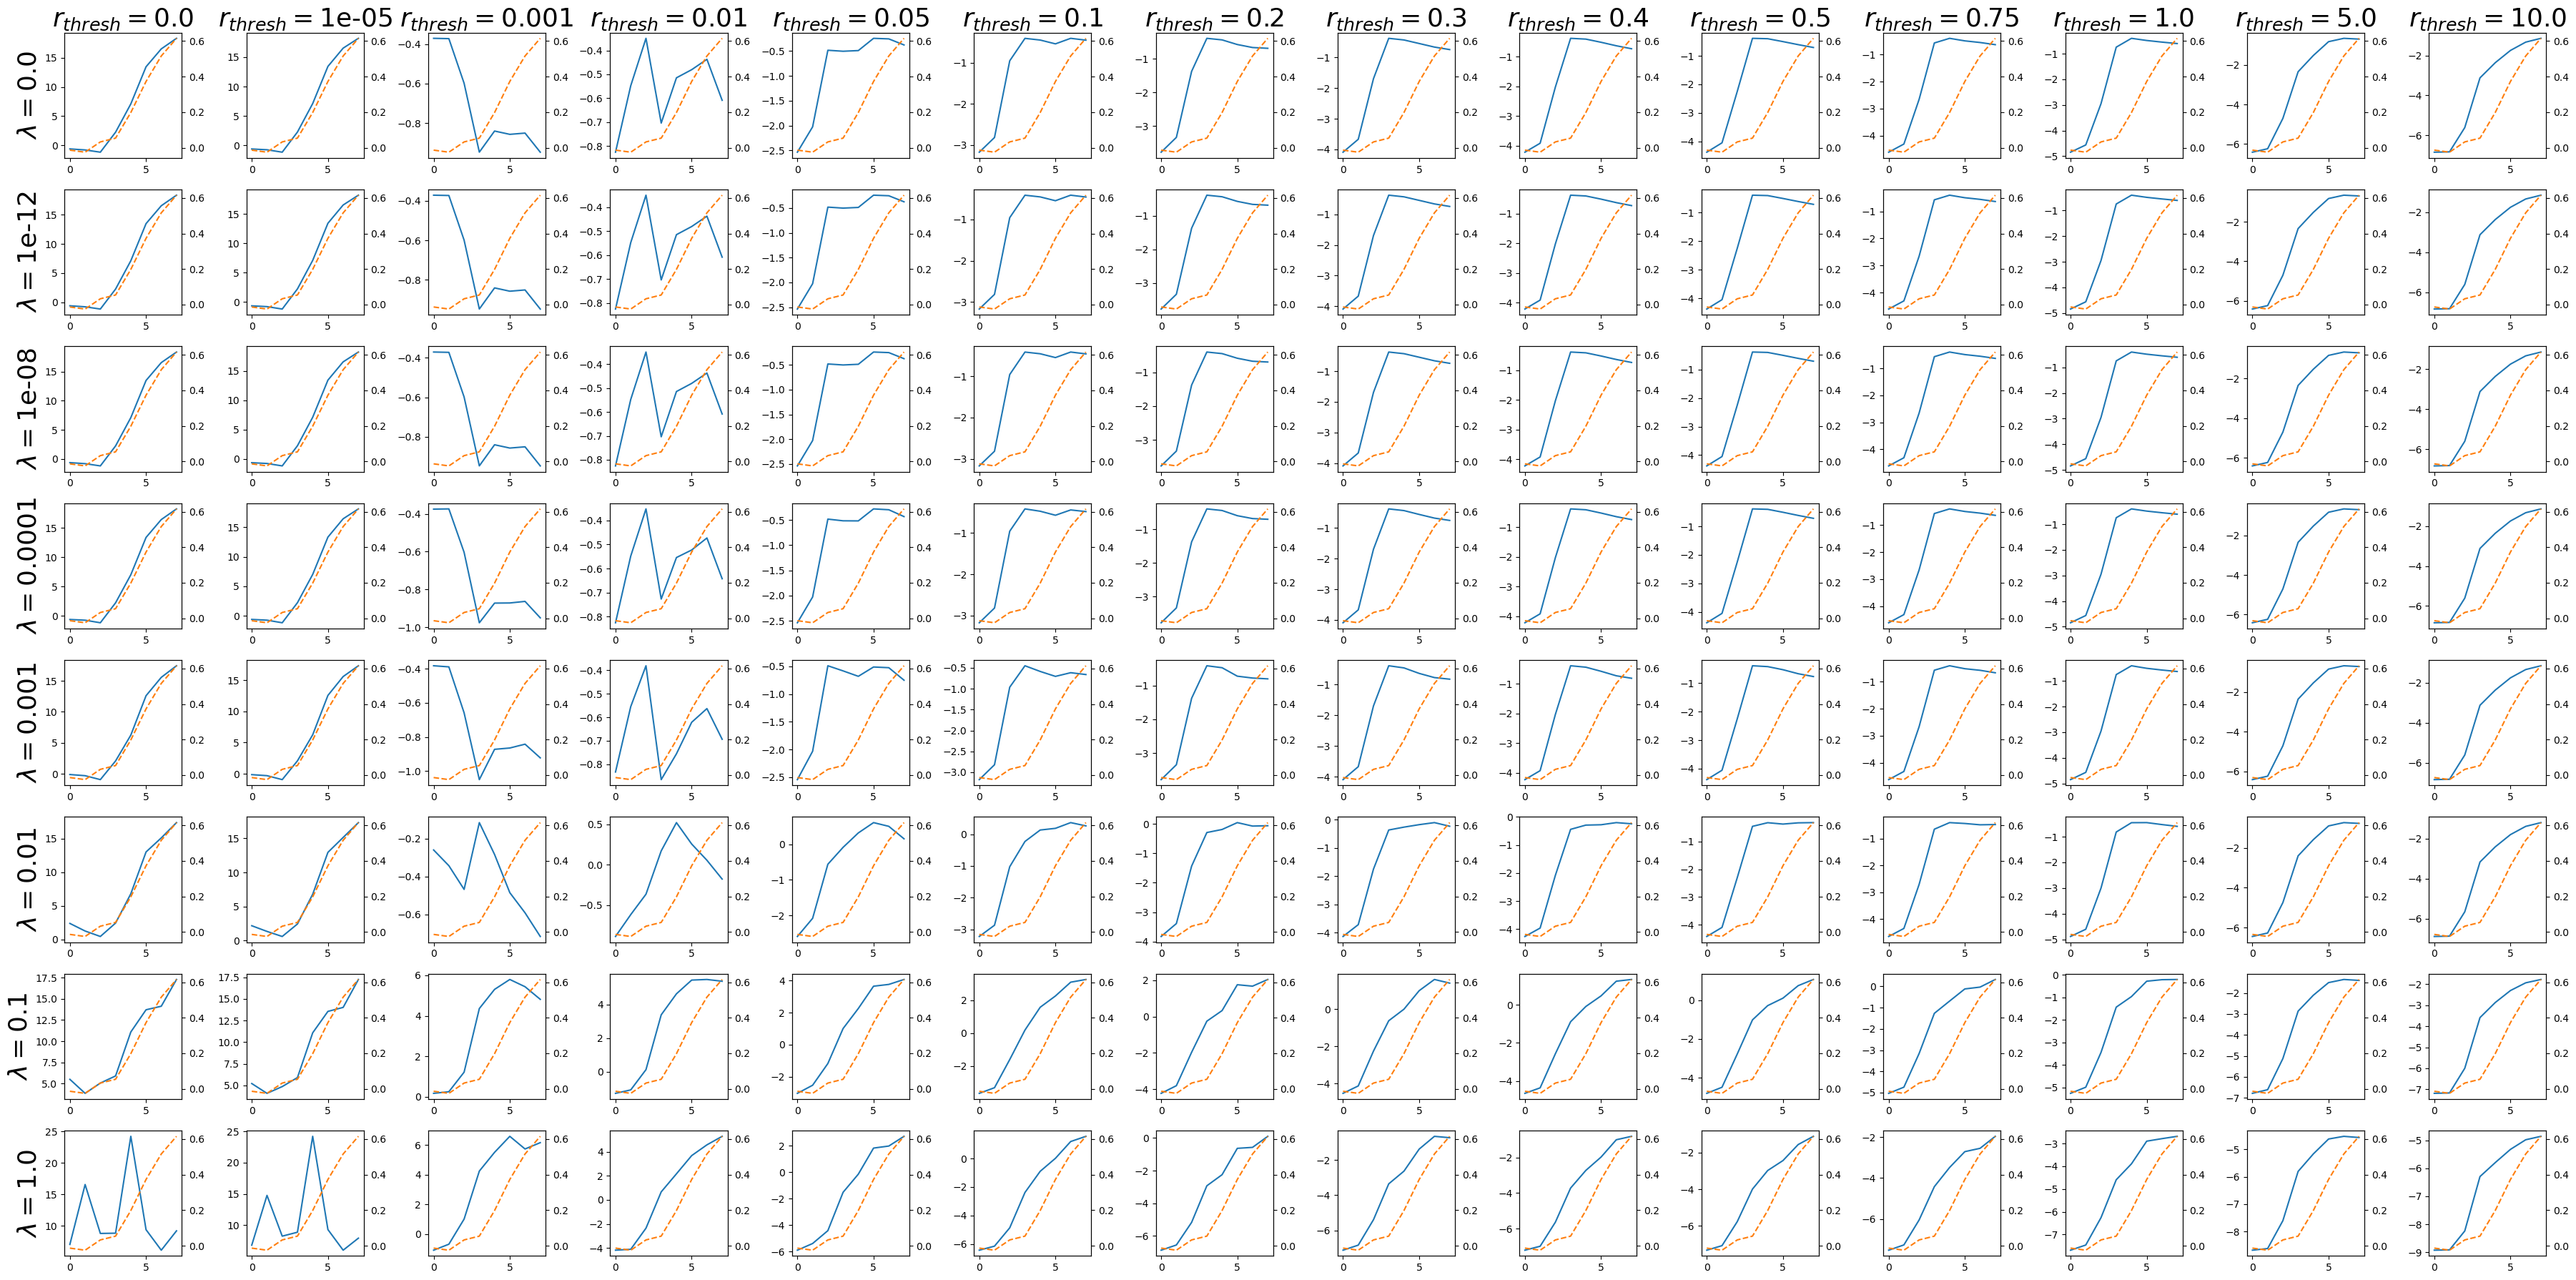

In [50]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
top_percent = 0.1
r_thresh_vals = results[keys[0]].r_thresh.unique()
lamb_vals = results[keys[0]].lamb.unique()

fig, axs = plt.subplots(len(lamb_vals), len(r_thresh_vals), figsize=(36, 18))
for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = [results[key][np.logical_and(results[key].r_thresh == r_thresh, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy()[0] for key in keys]
        ax = axs[j, i]
        ax.plot(curve)
        ax2 = ax.twinx()
        ax2.plot([lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
#         ax2.plot([lyaps[key][:int(len(lyaps[key])*top_percent)].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r_{thresh} = $" + f"{r_thresh}", fontsize=26)
plt.tight_layout()
plt.show()

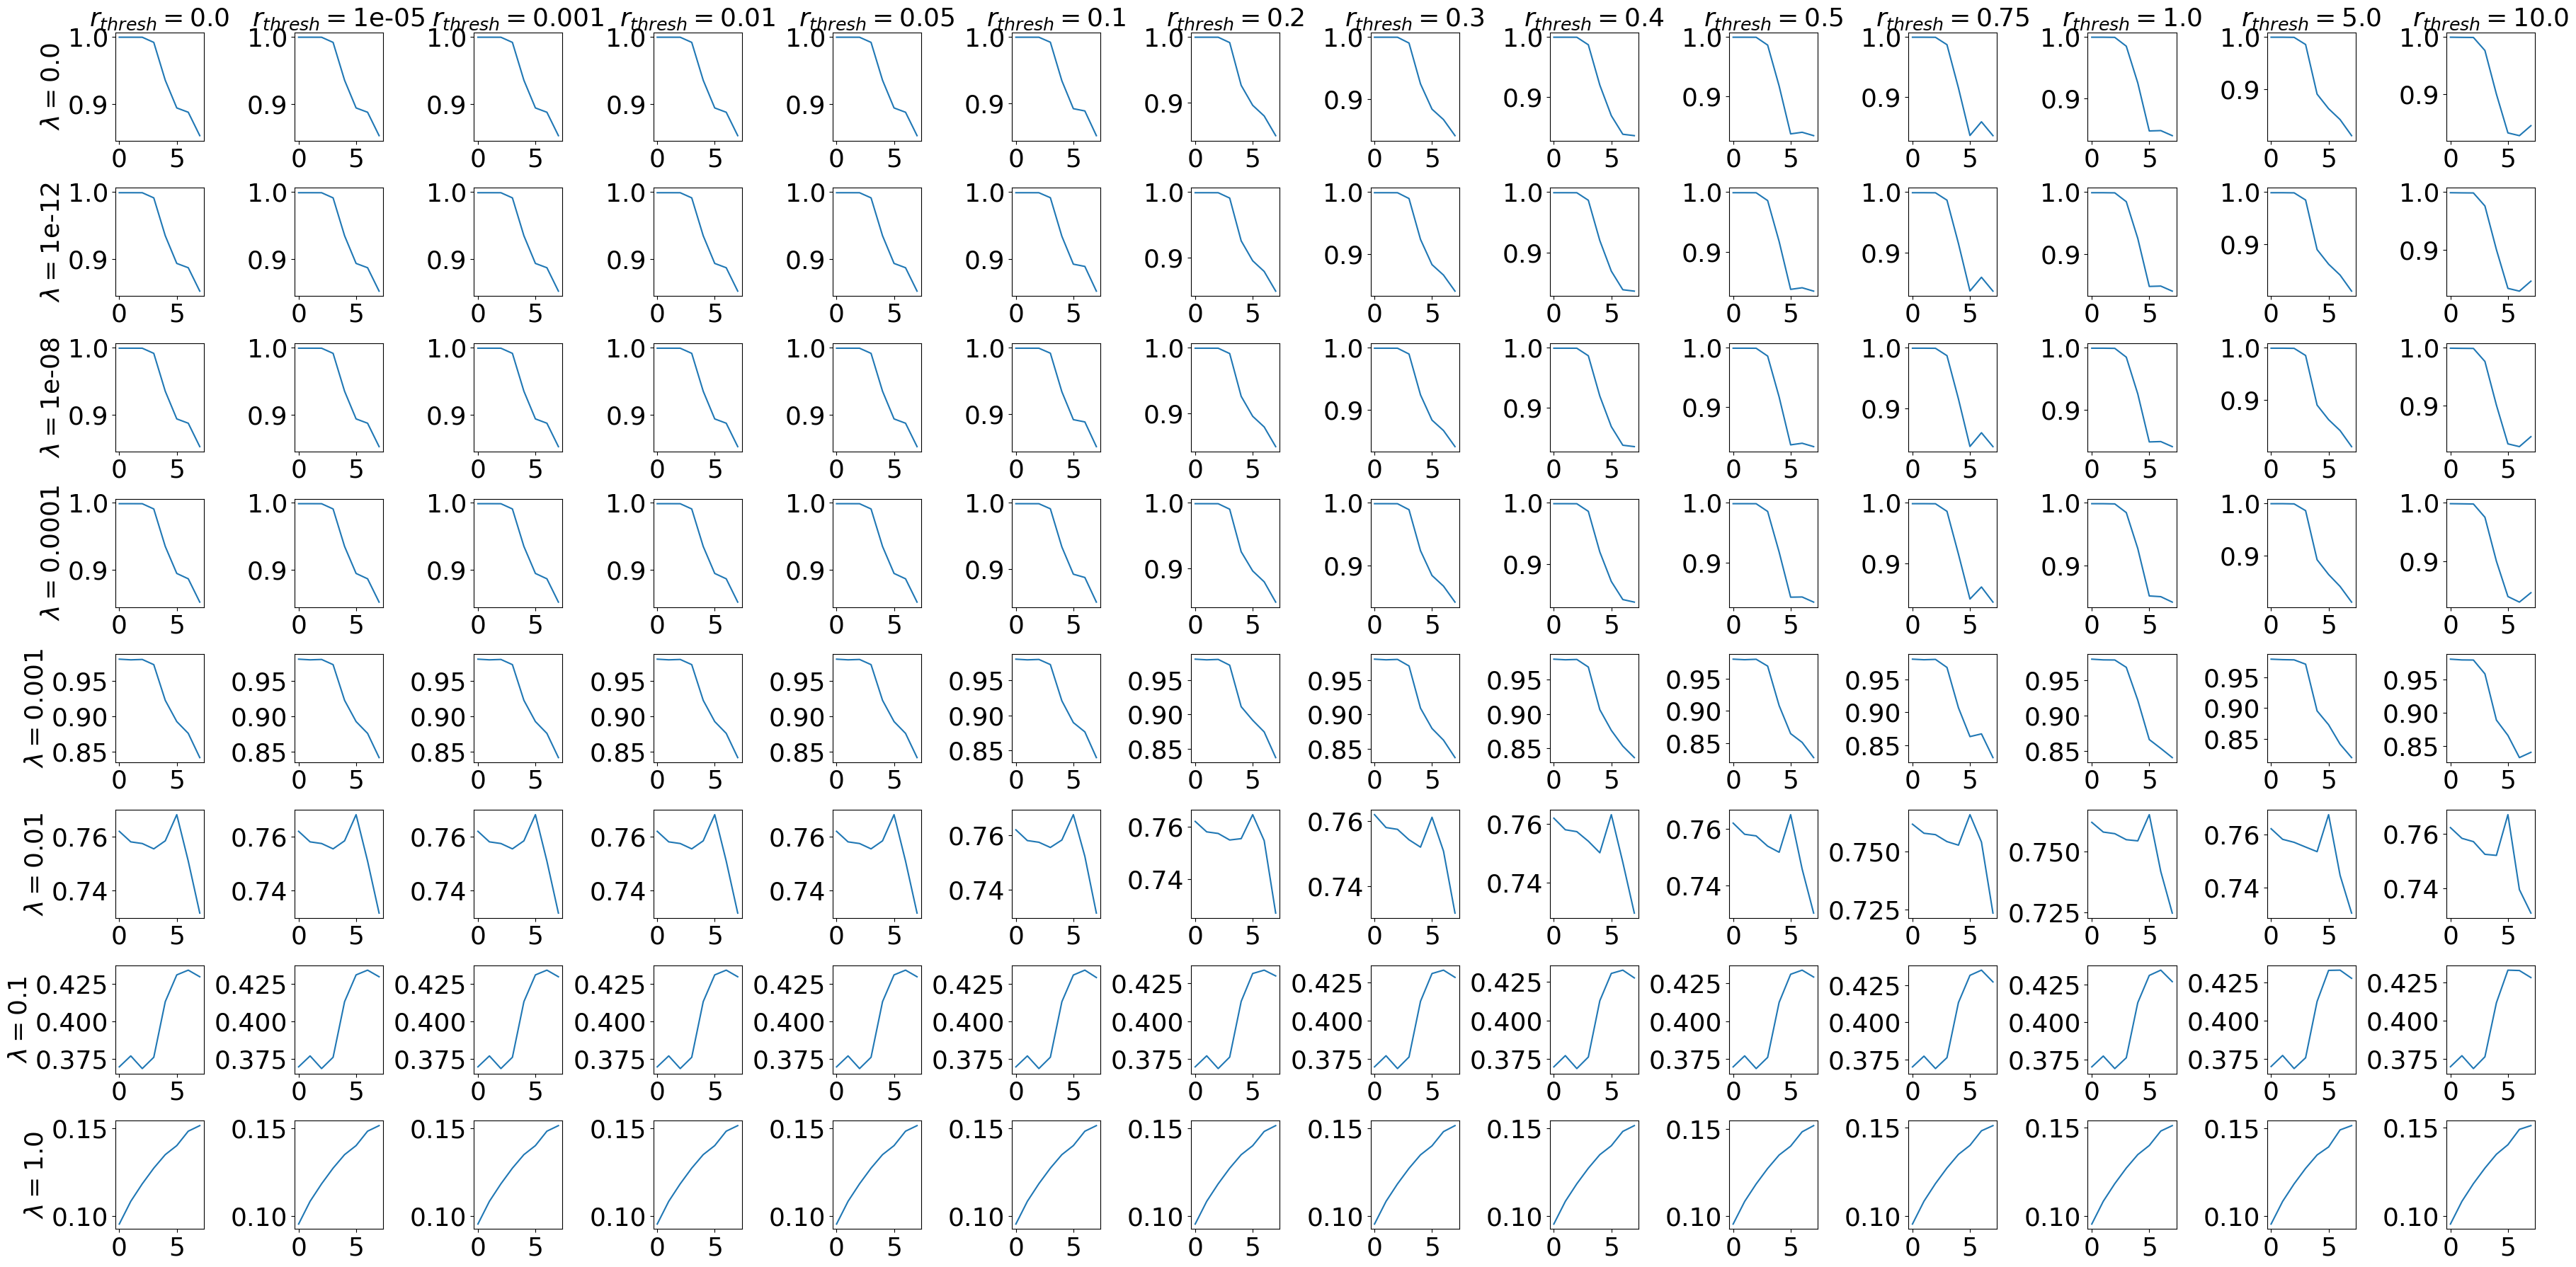

In [46]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
top_percent = 0.1
r_thresh_vals = results[keys[0]].r_thresh.unique()
lamb_vals = results[keys[0]].lamb.unique()

fig, axs = plt.subplots(len(lamb_vals), len(r_thresh_vals), figsize=(36, 18))
for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = [results[key][np.logical_and(results[key].r_thresh == r_thresh, results[key].lamb == lamb)].ip for key in keys]
        ax = axs[j, i]
        ax.plot(curve)
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r_{thresh} = $" + f"{r_thresh}", fontsize=26)
        ax.tick_params(labelsize=26)
plt.tight_layout()
plt.show()

# Adding Noise

In [24]:
standard_devs = [0, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 5, 10]
signal = signals[1.5][:15000]
signal = (signal - signal.mean())/signal.std()

In [25]:
p = int(6400/50)

In [26]:
S_vals = []
for sd in tqdm(standard_devs):
    delase = DeLASE(signal + np.random.randn(*signal.shape)*sd, p=p, use_torch=True, device='cuda')
    S_vals.append(delase.S.cpu())

  0%|          | 0/11 [00:00<?, ?it/s]

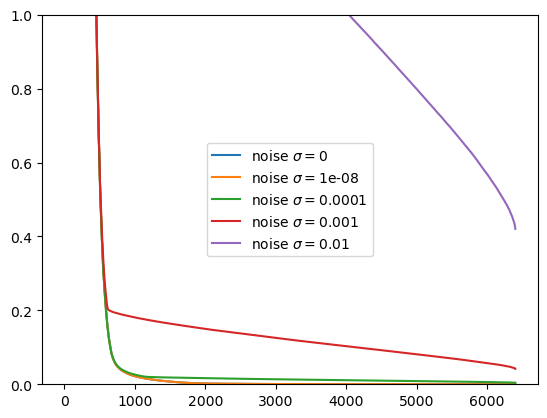

In [33]:
for i in range(len(S_vals[:5])):
    plt.plot(S_vals[i], label='noise $\sigma = $' + f"{standard_devs[i]}")
plt.ylim([0, 1])
plt.legend()

# Old

In [13]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
constraints = results[keys[0]].r_thresh >= 0
ip = np.zeros(len(results[keys[0]][constraints]))

for key in keys:
    ip += results[key][constraints].ip
ip /= len(keys)

In [14]:
max_ind = ip.argmax()
row = results[keys[0]][constraints].iloc[max_ind]
window, p, r_thresh, lamb = row.window, row.p, row.r_thresh, row.lamb

In [21]:
r_thresh, lamb

(0.25, 0.0001)

In [15]:
n = len(results[key][constraints].iloc[max_ind].stability_params)

In [16]:
stab_means = [results[key][constraints].iloc[max_ind].stability_params[:int(n*0.01)].mean() for key in keys]
lyap_means = [lyaps[key][:1].mean() for key in keys]

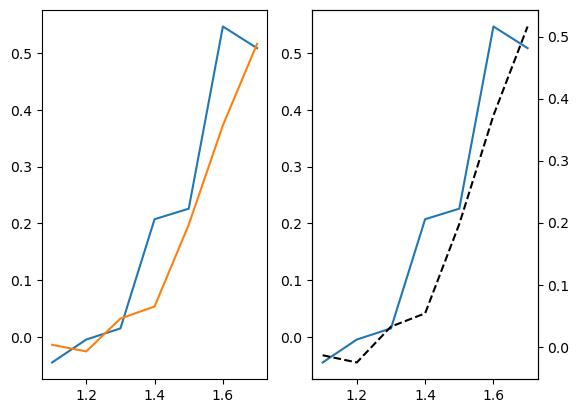

In [17]:
plt.subplot(1, 2, 1)
plt.plot(keys, stab_means)
plt.plot(keys, lyap_means)

plt.subplot(1, 2, 2)
plt.plot(keys, stab_means)
ax2 = plt.gca().twinx()
ax2.plot(keys, lyap_means, c='k', linestyle='--')

plt.show()

In [18]:
stab_means = [results[key][constraints].iloc[max_ind].stability_params[:int(n*0.4)].mean() for key in keys]
lyap_means = [lyaps[key][:1].mean() for key in keys]

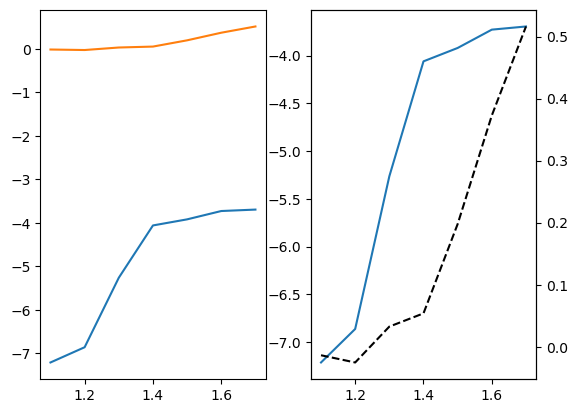

In [19]:
plt.subplot(1, 2, 1)
plt.plot(keys, stab_means)
plt.plot(keys, lyap_means)

plt.subplot(1, 2, 2)
plt.plot(keys, stab_means)
ax2 = plt.gca().twinx()
ax2.plot(keys, lyap_means, c='k', linestyle='--')

plt.show()